# Lab Assignments
Filip Moreau  
Advanced Machine Learning - DA633E, VT22

## General

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random


import seaborn as sns   # pip install seaborn
import cv2              # pip install opencv-python

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
data_images_path = 'data/images/'
data_models_path = 'data/models/'
data_datasets_path = 'data/datasets/'

- - -
## Computer Vision

### Compare CNN with MLP

In [4]:
input_size  = 224*224   # images are 224x224 pixels
output_size = 1      # there is 1 class (hot dog/not hot dog)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(f'{data_datasets_path}/hotdog/{x}', data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

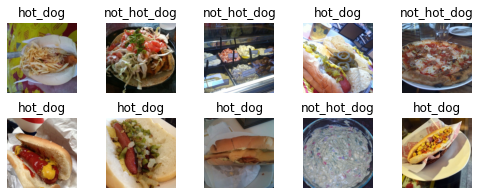

In [5]:
def imshow():
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    plt.figure(figsize=(7, 2.8))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        
        image, label = dataloaders['train'].dataset[random.randint(0, len(dataloaders['train'].dataset))]
        image = image.permute(1,2,0)
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.imshow(image.squeeze()); plt.axis('off')
        plt.title(f'{class_names[label]}')
        
    plt.tight_layout()


def imshow2(images, labels):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    plt.figure(figsize=(7, 2.8))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        
        images[i] = images[i].permute(1,2,0)
        images[i] = std * images[i] + mean
        images[i] = np.clip(images[i], 0, 1)
        plt.imshow(images[i].squeeze()); plt.axis('off')
        plt.title(f'{class_names[labels[i]]}')
        
    plt.tight_layout()


imshow()

In [6]:
loss_train_cnn = []
loss_train_mlp = []
accuracy_train_cnn = []
accuracy_train_mlp = []
precision_train_cnn = []
precision_train_mlp = []
recall_train_cnn = []
recall_train_mlp = []
f1_train_cnn = []
f1_train_mlp = []

loss_test_cnn = []
loss_test_mlp = []
accuracy_test_cnn = []
accuracy_test_mlp = []
precision_test_cnn = []
precision_test_mlp = []
recall_test_cnn = []
recall_test_mlp = []
f1_test_cnn = []
f1_test_mlp = []

In [7]:
def train_model(model, criterion, optimizer):
    model.train()
    loss = 0.0
    corrects = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for X, y in dataloaders['train']:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        pred = model(X)
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        
        loss += loss.item() * X.size(0)
        corrects += (pred.argmax(1) == y).type(torch.float).sum().item()
        true_positives += ((pred.argmax(1) == y) & (pred.argmax(1) == 0)).type(torch.float).sum()  # 0 = hot dog => Positive
        false_positives += ((pred.argmax(1) != y) & (pred.argmax(1) == 0)).type(torch.float).sum() # 0 = hot dog => Positive
        false_negatives += ((pred.argmax(1) != y) & (pred.argmax(1) == 1)).type(torch.float).sum() # 1 = not hot dog => Negative


    epoch_loss = loss / dataset_sizes['train']
    epoch_accuracy = corrects / dataset_sizes['train']
    epoch_precision = true_positives / (true_positives + false_positives)
    epoch_recall = true_positives / (true_positives + false_negatives)
    epoch_f1 = (2 * epoch_recall * epoch_precision) / (epoch_recall + epoch_precision)

    if model == model_cnn:
        loss_train_cnn.append(epoch_loss)
        accuracy_train_cnn.append(epoch_accuracy)
        precision_train_cnn.append(epoch_precision)
        recall_train_cnn.append(epoch_recall)
        f1_train_cnn.append(epoch_f1)
    else:
        loss_train_mlp.append(epoch_loss)
        accuracy_train_mlp.append(epoch_accuracy)
        precision_train_mlp.append(epoch_precision)
        recall_train_mlp.append(epoch_recall)
        f1_train_mlp.append(epoch_f1)

    print(f'  TRAIN\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_accuracy:.4f}  |  precision: {epoch_precision:.4f}  |  recall: {epoch_recall:.4f}  |  F1-score: {epoch_f1:.4f}')

#####

def test_model(model, criterion):
    model.eval()
    loss = 0.0
    corrects = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for X, y in dataloaders['test']:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            pred = model(X)
        loss = criterion(pred, y)
        
        loss += loss.item() * X.size(0)
        corrects += (pred.argmax(1) == y).type(torch.float).sum().item()
        true_positives += ((pred.argmax(1) == y) & (pred.argmax(1) == 0)).type(torch.float).sum()  # 0 = hot dog => Positive
        false_positives += ((pred.argmax(1) != y) & (pred.argmax(1) == 0)).type(torch.float).sum() # 0 = hot dog => Positive
        false_negatives += ((pred.argmax(1) != y) & (pred.argmax(1) == 1)).type(torch.float).sum() # 1 = not hot dog => Negative
        

    epoch_loss = loss / dataset_sizes['test']
    epoch_accuracy = corrects / dataset_sizes['test']
    epoch_precision = true_positives / (true_positives + false_positives)
    epoch_recall = true_positives / (true_positives + false_negatives)
    epoch_f1 = (2 * epoch_recall * epoch_precision) / (epoch_recall + epoch_precision)

    if model == model_cnn:
        loss_test_cnn.append(epoch_loss)
        accuracy_test_cnn.append(epoch_accuracy)
        precision_test_cnn.append(epoch_precision)
        recall_test_cnn.append(epoch_recall)
        f1_test_cnn.append(epoch_f1)
    else:
        loss_test_mlp.append(epoch_loss)
        accuracy_test_mlp.append(epoch_accuracy)
        precision_test_mlp.append(epoch_precision)
        recall_test_mlp.append(epoch_recall)
        f1_test_mlp.append(epoch_f1)

    print(f'  TEST\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_accuracy:.4f}  |  precision: {epoch_precision:.4f}  |  recall: {epoch_recall:.4f}  |  F1-score: {epoch_f1:.4f}')

#####

def visualize_model(model):
    model.eval()

    images = [None]*10
    labels = [None]*10
    counter = 0

    for X, y in dataloaders['test']:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            pred = model(X)
            
        print()

        for j in range(X.size()[0]):
            images[counter] = X[j].cpu()
            labels[counter] = pred.argmax(1)[j].cpu()

            counter += 1
            if (counter >= 10):
                imshow2(images, labels)
                return

In [8]:
n_features = 10
learning_rate = 0.01
momentum = 0.5
epochs = 25

#### CNN

In [9]:
class CNN(nn.Module):
    def __init__(self, n_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_features, kernel_size=5)
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)

        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(n_features*53*53, 1024)
        self.fc2 = nn.Linear(1024, 2)   
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [10]:
model_cnn = CNN(n_features)
model_cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=learning_rate, momentum=momentum)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(model_cnn)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)))

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28090, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)
Number of parameters: 28770504


In [11]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    train_model(model_cnn, criterion, optimizer)
    test_model(model_cnn, criterion)
    scheduler.step()

Epoch 1/25


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  TRAIN	 loss: 0.0043  |  accuracy: 0.5000  |  precision: 0.5000  |  recall: 0.5100  |  F1-score: 0.5050
  TEST	 loss: 0.0070  |  accuracy: 0.5060  |  precision: 0.5031  |  recall: 0.9760  |  F1-score: 0.6639
Epoch 2/25
  TRAIN	 loss: 0.0043  |  accuracy: 0.5301  |  precision: 0.5316  |  recall: 0.5060  |  F1-score: 0.5185
  TEST	 loss: 0.0067  |  accuracy: 0.5140  |  precision: 0.5074  |  recall: 0.9600  |  F1-score: 0.6639
Epoch 3/25
  TRAIN	 loss: 0.0039  |  accuracy: 0.5341  |  precision: 0.5321  |  recall: 0.5663  |  F1-score: 0.5486
  TEST	 loss: 0.0069  |  accuracy: 0.5460  |  precision: 0.5827  |  recall: 0.3240  |  F1-score: 0.4165
Epoch 4/25
  TRAIN	 loss: 0.0042  |  accuracy: 0.5361  |  precision: 0.5484  |  recall: 0.4096  |  F1-score: 0.4690
  TEST	 loss: 0.0073  |  accuracy: 0.5120  |  precision: 0.5066  |  recall: 0.9240  |  F1-score: 0.6544
Epoch 5/25
  TRAIN	 loss: 0.0043  |  accuracy: 0.5462  |  precision: 0.5358  |  recall: 0.6908  |  F1-score: 0.6035
  TEST	 loss: 0

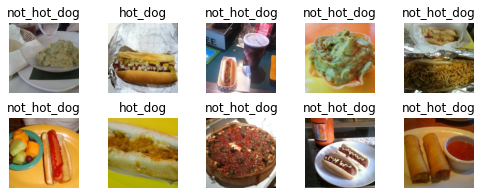

In [41]:
visualize_model(model_cnn)

#### MLP

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size*3, 1024), #224*224*3
            nn.ReLU(),
            nn.Linear(1024, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
     
    def forward(self, x):
        x = self.layers(x)
        return F.log_softmax(x, dim=1)

In [13]:
model_mlp = MLP()
model_mlp.to(device)

optimizer = optim.SGD(model_mlp.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(model_mlp)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)))

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=2, bias=True)
  )
)
Number of parameters: 154244398


In [14]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    train_model(model_mlp, criterion, optimizer)
    test_model(model_mlp, criterion)
    scheduler.step()

Epoch 1/25
  TRAIN	 loss: 0.0021  |  accuracy: 0.5663  |  precision: 0.5789  |  recall: 0.4859  |  F1-score: 0.5284
  TEST	 loss: 0.0067  |  accuracy: 0.5240  |  precision: 0.5417  |  recall: 0.3120  |  F1-score: 0.3959
Epoch 2/25
  TRAIN	 loss: 0.0035  |  accuracy: 0.6807  |  precision: 0.6860  |  recall: 0.6667  |  F1-score: 0.6762
  TEST	 loss: 0.0047  |  accuracy: 0.5600  |  precision: 0.5833  |  recall: 0.4200  |  F1-score: 0.4884
Epoch 3/25
  TRAIN	 loss: 0.0034  |  accuracy: 0.7390  |  precision: 0.7532  |  recall: 0.7108  |  F1-score: 0.7314
  TEST	 loss: 0.0079  |  accuracy: 0.6260  |  precision: 0.6684  |  recall: 0.5000  |  F1-score: 0.5721
Epoch 4/25
  TRAIN	 loss: 0.0025  |  accuracy: 0.7771  |  precision: 0.7899  |  recall: 0.7550  |  F1-score: 0.7721
  TEST	 loss: 0.0109  |  accuracy: 0.5520  |  precision: 0.6444  |  recall: 0.2320  |  F1-score: 0.3412
Epoch 5/25
  TRAIN	 loss: 0.0020  |  accuracy: 0.7972  |  precision: 0.8274  |  recall: 0.7510  |  F1-score: 0.7874
  TE

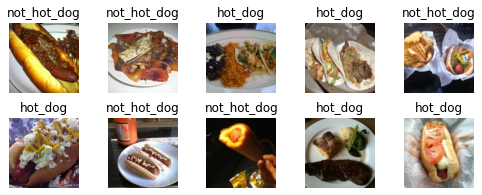

In [15]:
visualize_model(model_mlp)

### Calculate, plot, analyze, and compare different metrics

#### Loss, Accuracy, Precision, Recall, F1-score

In [20]:
def plot_comparison(train_cnn, test_cnn, train_mlp, test_mlp, title):
    plt.figure(figsize = (14, 5))

    train_cnn = torch.tensor(train_cnn, device = 'cpu')
    test_cnn = torch.tensor(test_cnn, device = 'cpu')
    train_mlp = torch.tensor(train_mlp, device = 'cpu')
    test_mlp = torch.tensor(test_mlp, device = 'cpu')

    plt.subplot(1, 2, 1)
    with torch.no_grad():
        plt.plot(range(len(train_cnn)), train_cnn, label = "train")
    plt.plot(range(len(test_cnn)), test_cnn, label = "test")
    plt.title(f'CNN - {title}')
    plt.xlabel('epoch')
    plt.ylabel(title)
    plt.legend()

    plt.subplot(1, 2, 2)
    with torch.no_grad():
        plt.plot(range(len(train_mlp)), train_mlp, label = "train")
    plt.plot(range(len(test_mlp)), test_mlp, label = "test")
    plt.title(f'MLP - {title}')
    plt.xlabel('epoch')
    plt.ylabel(title)
    plt.legend()
    
    plt.savefig(f'comparison_CNN_MLP_{title}.png')
    plt.show()

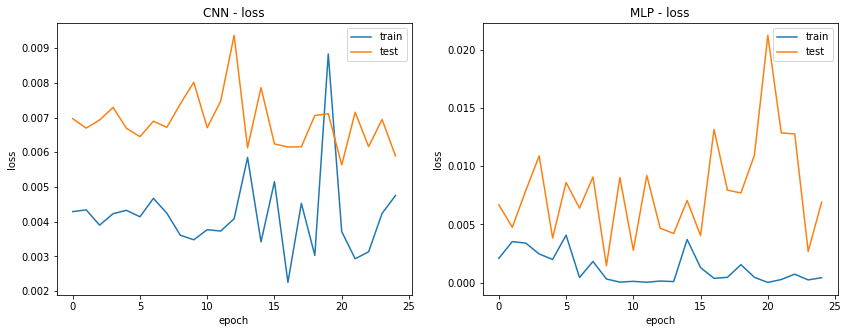

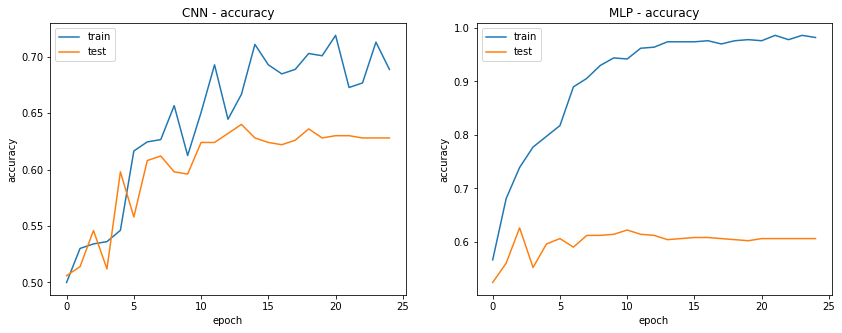

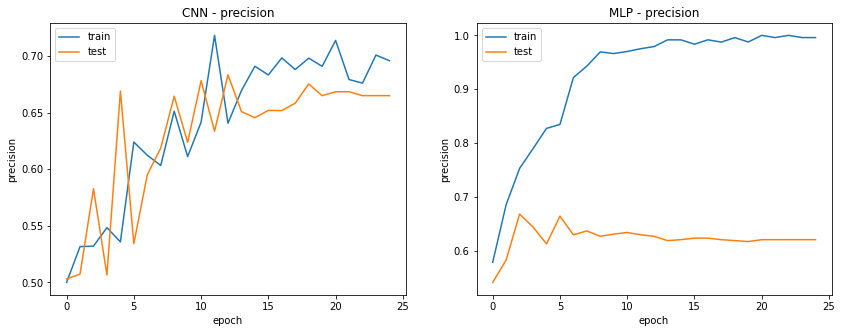

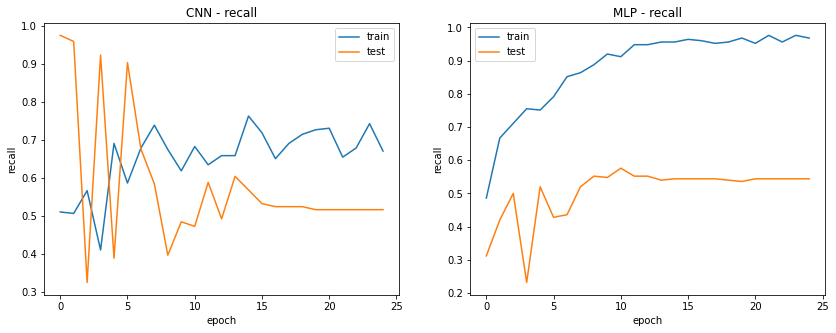

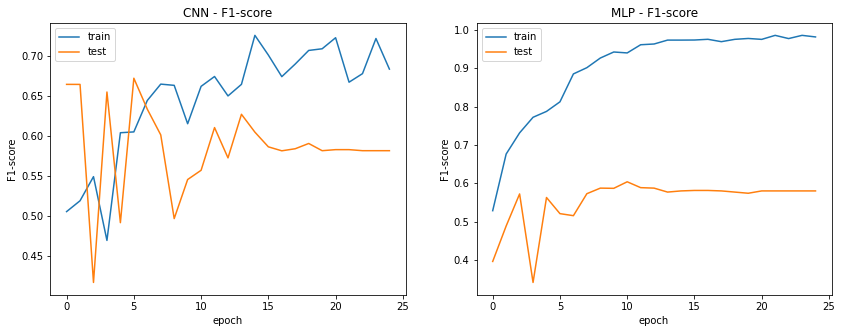

In [21]:
plot_comparison(loss_train_cnn, loss_test_cnn, loss_train_mlp, loss_test_mlp, 'loss')
plot_comparison(accuracy_train_cnn, accuracy_test_cnn, accuracy_train_mlp, accuracy_test_mlp, 'accuracy')
plot_comparison(precision_train_cnn, precision_test_cnn, precision_train_mlp, precision_test_mlp, 'precision')
plot_comparison(recall_train_cnn, recall_test_cnn, recall_train_mlp, recall_test_mlp, 'recall')
plot_comparison(f1_train_cnn, f1_test_cnn, f1_train_mlp, f1_test_mlp, 'F1-score')

### Fine-tune pretrained models

In [48]:
# !unzip f'{data_datasets_path}hymenoptera/hymenoptera_data.zip' -d f'{data_datasets_path}hymenoptera'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(f'{data_datasets_path}/hymenoptera/{x}', data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

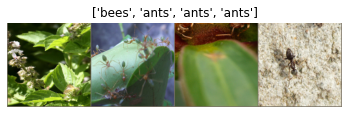

In [49]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [50]:
def train_model(model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']

    print(f'  TRAIN\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_acc:.4f}')


def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']

    print(f'  TEST\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_acc:.4f}')


def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0

    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {class_names[preds[j]]}')
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

#### by freezing weights

In [51]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [52]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    train_model(model_ft, criterion, optimizer_ft)
    test_model(model_ft, criterion)
    scheduler.step()

Epoch 1/15
  TRAIN	 loss: 0.5494  |  accuracy: 0.6762
  TEST	 loss: 0.1834  |  accuracy: 0.9412
Epoch 2/15
  TRAIN	 loss: 0.4920  |  accuracy: 0.7705
  TEST	 loss: 0.2212  |  accuracy: 0.9150
Epoch 3/15
  TRAIN	 loss: 0.3889  |  accuracy: 0.8197
  TEST	 loss: 0.1896  |  accuracy: 0.9346
Epoch 4/15
  TRAIN	 loss: 0.5520  |  accuracy: 0.7459
  TEST	 loss: 0.3422  |  accuracy: 0.8497
Epoch 5/15
  TRAIN	 loss: 0.5532  |  accuracy: 0.7705
  TEST	 loss: 0.2140  |  accuracy: 0.9281
Epoch 6/15
  TRAIN	 loss: 0.4178  |  accuracy: 0.8361
  TEST	 loss: 0.1993  |  accuracy: 0.9281
Epoch 7/15
  TRAIN	 loss: 0.6000  |  accuracy: 0.7500
  TEST	 loss: 0.4335  |  accuracy: 0.8366
Epoch 8/15
  TRAIN	 loss: 0.4265  |  accuracy: 0.8074
  TEST	 loss: 0.1528  |  accuracy: 0.9346
Epoch 9/15
  TRAIN	 loss: 0.3213  |  accuracy: 0.8484
  TEST	 loss: 0.1853  |  accuracy: 0.9346
Epoch 10/15
  TRAIN	 loss: 0.3650  |  accuracy: 0.8525
  TEST	 loss: 0.1536  |  accuracy: 0.9412
Epoch 11/15
  TRAIN	 loss: 0.3581  |  a

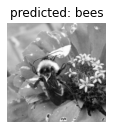

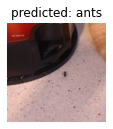

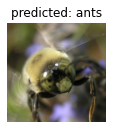

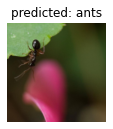

In [53]:
visualize_model(model_ft, 4)

#### by reconstructing the layers

In [54]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [55]:
class MyAlexNET(nn.Module):
    def __init__(self):
        super(MyAlexNET, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=2, bias=True)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.softmax(x, dim=1)

In [56]:
model_myAlexNET = MyAlexNET()
print(model_myAlexNET)
model_myAlexNET = model_myAlexNET.to(device)

MyAlexNET(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)

In [57]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    train_model(model_myAlexNET, criterion, optimizer_ft)
    test_model(model_myAlexNET, criterion)
    scheduler.step()

Epoch 1/15
  TRAIN	 loss: 0.6931  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 2/15
  TRAIN	 loss: 0.6932  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 3/15
  TRAIN	 loss: 0.6931  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 4/15
  TRAIN	 loss: 0.6931  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 5/15
  TRAIN	 loss: 0.6930  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 6/15
  TRAIN	 loss: 0.6930  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 7/15
  TRAIN	 loss: 0.6932  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 8/15
  TRAIN	 loss: 0.6933  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 9/15
  TRAIN	 loss: 0.6932  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 10/15
  TRAIN	 loss: 0.6931  |  accuracy: 0.4959
  TEST	 loss: 0.6926  |  accuracy: 0.5425
Epoch 11/15
  TRAIN	 loss: 0.6931  |  a

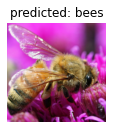

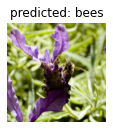

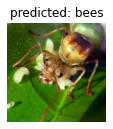

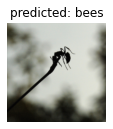

In [58]:
visualize_model(model_myAlexNET, 4)

### Segmentation

#### Use Mask R-CNN to do instance segmentation 

In [59]:
coco_labels = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush' ]

colors = np.random.uniform(50, 150, (len(coco_labels), 3))

In [60]:
%%capture
model_rcnn = models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=len(coco_labels))
model_rcnn = model_rcnn.to(device)
model_rcnn.eval()

In [87]:
def get_segmentation(img, threshold):  
    transform = T.Compose([
        T.ToTensor()])

    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    
    with torch.no_grad():
        pred = model_rcnn(img)

    pred_scores = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = len([pred_scores.index(x) for x in pred_scores if x > threshold])

    masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
    masks = masks[:pred_t]

    boxes = [[int(i[0]), int(i[1]), int(i[2]), int(i[3])] for i in pred[0]['boxes'].detach().cpu()]
    boxes = boxes[:pred_t]

    classes = [coco_labels[i] for i in pred[0]['labels']]
    classes = classes[:pred_t]

    return masks, boxes, classes, pred_scores

In [115]:
def draw_segmentation(img, masks, boxes, classes, scores):
    alpha = 0.6
    beta = 0.6
    gamma = 0

    img = img.point(lambda p: p * alpha)
    img = np.array(img)

    for i in range(len(masks)):
        r = np.zeros_like(masks[i]).astype(np.uint8)
        g = np.zeros_like(masks[i]).astype(np.uint8)
        b = np.zeros_like(masks[i]).astype(np.uint8)
        color = colors[random.randrange(0, len(colors))]
        r[masks[i] == 1], g[masks[i] == 1], b[masks[i] == 1] = color
        rgb = np.stack([r, g, b], axis=2)
   
        cv2.addWeighted(img, 1, rgb, beta, gamma, img)

        p1 = (boxes[i][0], boxes[i][1])
        p2 = (boxes[i][2], boxes[i][3])
        cv2.rectangle(img, p1, p2, color=color, thickness=2)

        text = f'{classes[i]} {scores[i]:.2}'
        p_text = (boxes[i][0], boxes[i][1] - 5)
        cv2.putText(img, text, p_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    return img

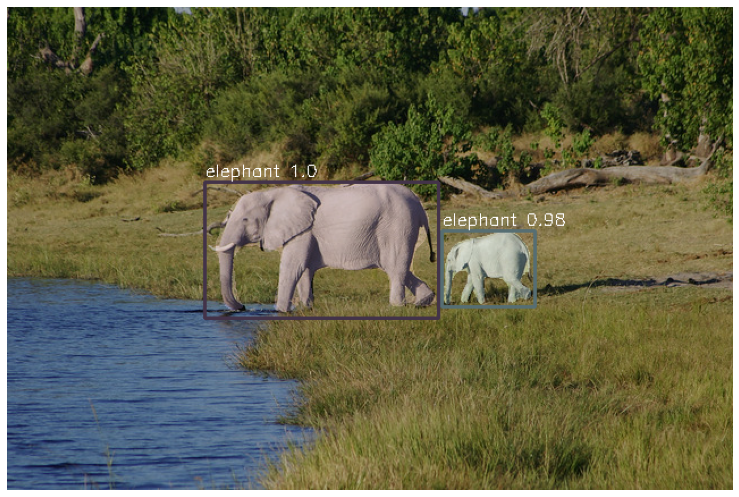

In [63]:
plt.figure(figsize=(13, 13))
img = Image.open(data_images_path + 'elephants.jpg')
img = img.convert('RGB')

masks, boxes, classes, scores = get_segmentation(img, 0.5)
img = draw_segmentation(img, masks, boxes, classes, scores)

plt.imshow(img); plt.axis('off'); plt.title(f''); plt.show()
plt.imsave('image_segmentation_elephants.png', img)

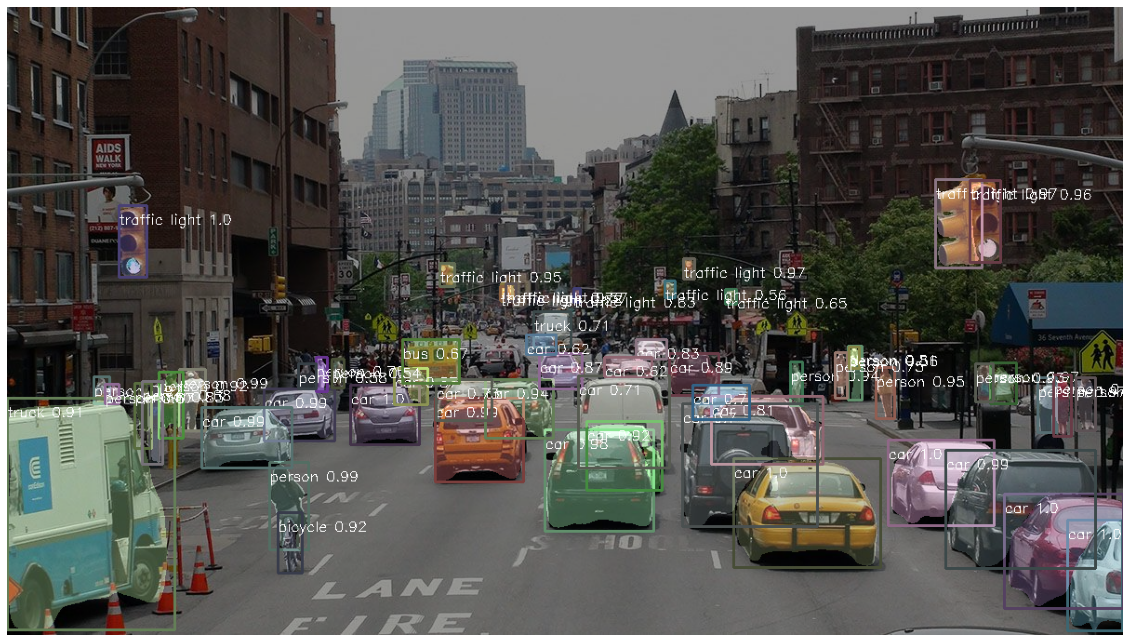

In [114]:
plt.figure(figsize=(20, 20))
img = Image.open(data_images_path + 'traffic_01.jpg')
img = img.convert('RGB')

masks, boxes, classes, scores = get_segmentation(img, 0.5)
img = draw_segmentation(img, masks, boxes, classes, scores)

plt.imshow(img); plt.axis('off'); plt.title(f''); plt.show()
plt.imsave('image_segmentation_traffic_01.png', img)

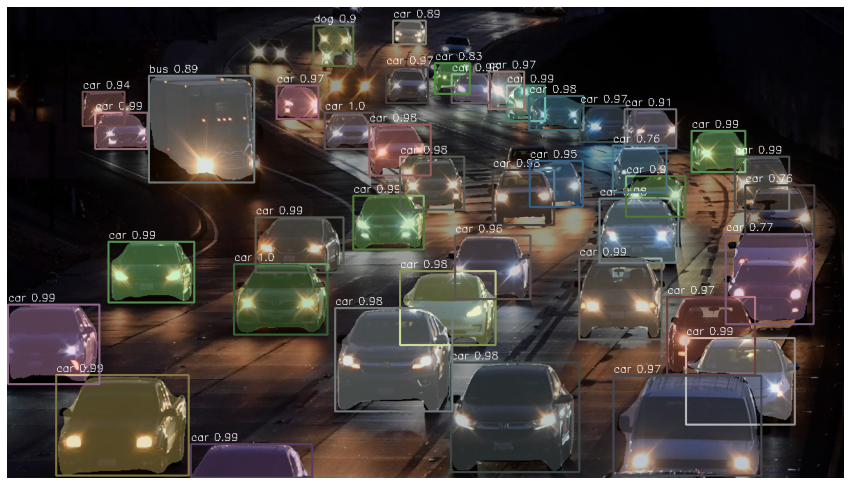

In [116]:
plt.figure(figsize=(15, 15))
img = Image.open(data_images_path + 'traffic_02.jpg')
img = img.convert('RGB')

masks, boxes, classes, scores = get_segmentation(img, 0.7)
img = draw_segmentation(img, masks, boxes, classes, scores)

plt.imshow(img); plt.axis('off'); plt.title(f''); plt.show()
plt.imsave('image_segmentation_traffic_02.png', img)

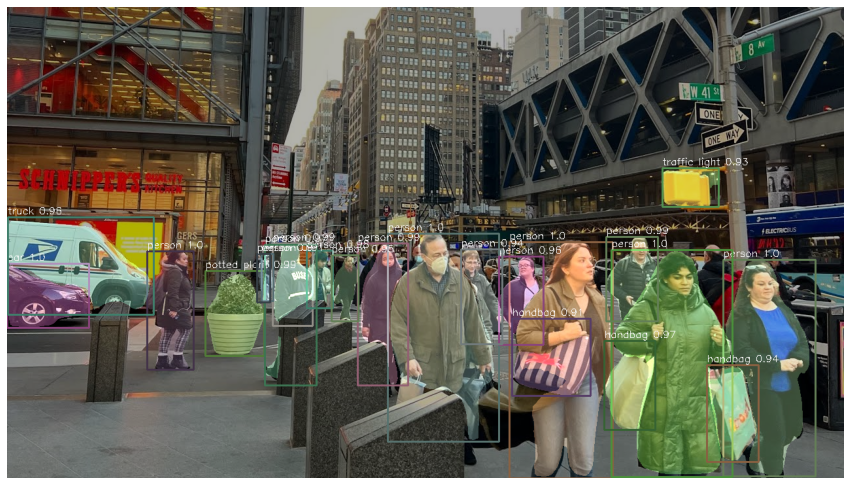

In [66]:
plt.figure(figsize=(15, 15))
img = Image.open(data_images_path + 'people_01.jpg')
img = img.convert('RGB')

masks, boxes, classes, scores = get_segmentation(img, 0.9)
img = draw_segmentation(img, masks, boxes, classes, scores)

plt.imshow(img); plt.axis('off'); plt.title(f''); plt.show()
plt.imsave('image_segmentation_people_01.png', img)

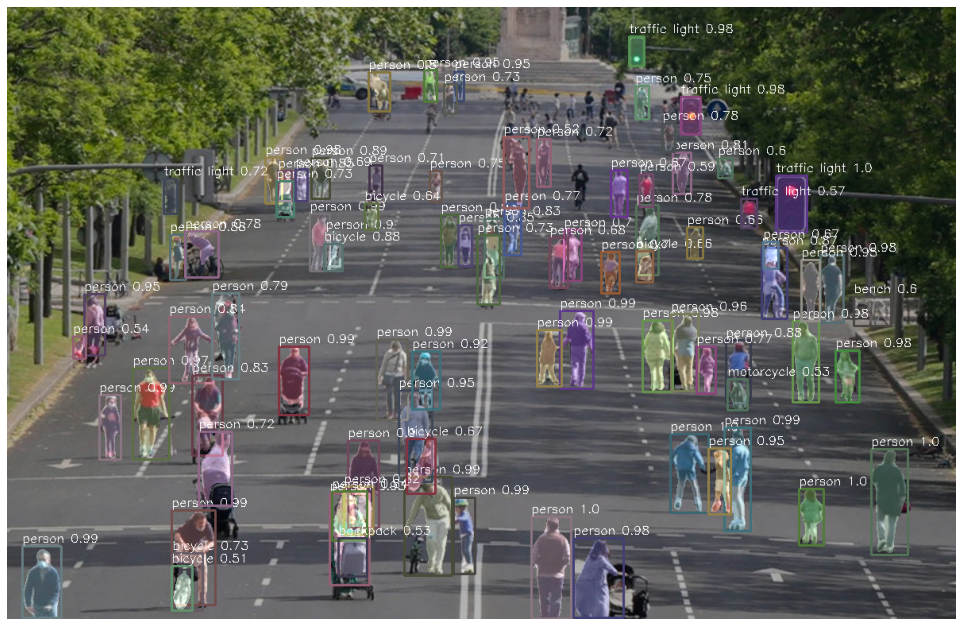

In [67]:
plt.figure(figsize=(17, 17))
img = Image.open(data_images_path + 'people_02.jpg')
img = img.convert('RGB')

masks, boxes, classes, scores = get_segmentation(img, 0.5)
img = draw_segmentation(img, masks, boxes, classes, scores)

plt.imshow(img); plt.axis('off'); plt.title(f''); plt.show()
plt.imsave('image_segmentation_people_02.png', img)

### CNN Visualization

#### Implement and apply occlusion to gather heatmap

In [68]:
model_resnet = models.resnet18(pretrained=True)

In [69]:
def test_single(img, label_index, show_top_k = False):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

    img = transform(img)
    img = torch.unsqueeze(img, 0)

    model_resnet.eval()
    with torch.no_grad():
        output = model_resnet(img)

    k = 5
    ratios = F.softmax(output, dim=1)[0]
    topk_vals, topk_inds = ratios.topk(k)
    
    class_prob = ratios[label_index].item()

    if show_top_k:
        print(f'top {k}:')
        for i in range(k):
            print(f'[{i+1}]  {topk_inds[i]}  {topk_vals[i]:.4}')

        print(f'class probability (class {label_index}): {class_prob:.5}\n')

    return class_prob

In [70]:
def occlusion(img, label_index, occ_size, occ_stride, debug_box_index=-1):
    img_width, img_height = img.size[0], img.size[1]
    
    out_width = int(np.ceil((img_width-occ_size)/occ_stride))
    out_height = int(np.ceil((img_height-occ_size)/occ_stride))

    heatmap = torch.zeros((out_height, out_width))
    
    counter = 0

    for h in range(img_height):
        for w in range(img_width):

            h_start = h * occ_stride
            h_end = min(img_height, h_start + occ_size)

            w_start = w * occ_stride
            w_end = min(img_width, w_start + occ_size)

            if h_end >= img_height or w_end >= img_width:
                continue

            img_copy = img.copy()
            pixels = img_copy.load()

            for i in range(w_start, w_end):
                for j in range(h_start, h_end):
                    pixels[i, j] = (128, 128, 128)
            
            if counter == debug_box_index:
                plt.imshow(img_copy); plt.axis('off'); plt.show()
            counter += 1

            class_prob = test_single(img_copy, label_index)
            heatmap[h, w] = class_prob

            
    return heatmap

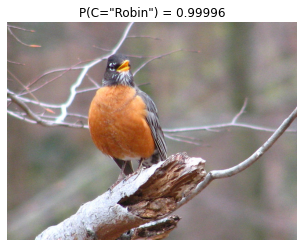

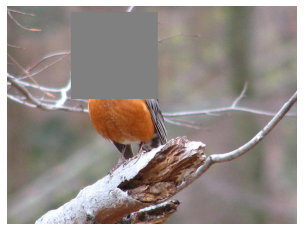

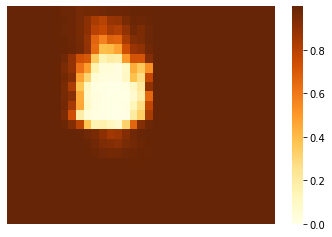

In [71]:
img = Image.open(data_images_path + 'robin.jpg')

P0 = test_single(img, 15)
plt.imshow(img); plt.axis('off'); plt.title(f'P(C="Robin") = {P0:.5}'); plt.show()

occ_heatmap = occlusion(img, 15, 150, 10, 46)
heatmap = sns.heatmap(occ_heatmap, xticklabels=False, yticklabels=False, vmin=0, vmax=P0, cmap=sns.color_palette('YlOrBr', as_cmap=True))
heatmap.get_figure().savefig('occlusion_heatmap_robin', dpi=300)

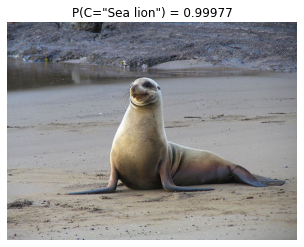

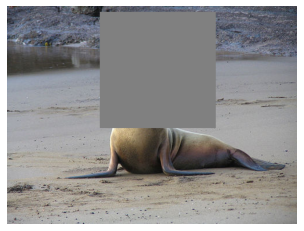

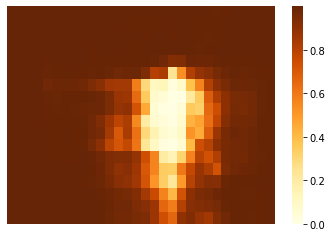

In [72]:
img = Image.open(data_images_path + 'sea_lion.jpg')

P0 = test_single(img, 150)
plt.imshow(img); plt.axis('off'); plt.title(f'P(C="Sea lion") = {P0:.5}'); plt.show()

occ_heatmap = occlusion(img, 150, 200, 10, 46)
heatmap = sns.heatmap(occ_heatmap, xticklabels=False, yticklabels=False, vmin=0, vmax=P0, cmap=sns.color_palette('YlOrBr', as_cmap=True))
heatmap.get_figure().savefig('occlusion_heatmap_sea_lion', dpi=300)

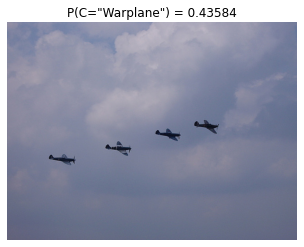

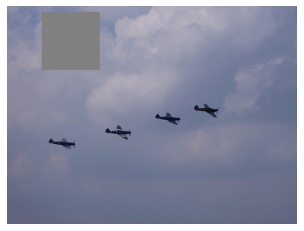

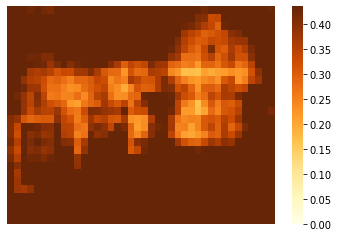

In [73]:
img = Image.open(data_images_path + 'warplane.jpg')

P0 = test_single(img, 895)
plt.imshow(img); plt.axis('off'); plt.title(f'P(C="Warplane") = {P0:.5}'); plt.show()

occ_heatmap = occlusion(img, 895, 100, 10, 46)
heatmap = sns.heatmap(occ_heatmap, xticklabels=False, yticklabels=False, vmin=0, vmax=P0, cmap=sns.color_palette('YlOrBr', as_cmap=True))
heatmap.get_figure().savefig('occlusion_heatmap_warplane', dpi=300)

- - -
## Language Models

### Compare RNN, LSTM, and GRU with perplexity

#### Implement GRU in the first Notebook

### Implement Skip-gram and compare embedding layers with CBOW

### Adapt/expand the text classifier in notebook 2 within the language models lab

- - -
## Generative Models

### Interpolate from one latent space to another latent space and visualize the transition using VAE

### Implement and test Conditional VAE (cVAE)

### Test VAE and GAN (or any of their variations) using another task or dataset than FashionMNIST or MNIST, and compare both approaches